In [1]:
import pandas
import datetime
import numpy
import scipy.optimize
import seaborn as sns
import matplotlib.pyplot as plt
import os
import time
import bs4
import urllib
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
%matplotlib inline

In [2]:
velsDataDF = pandas.read_csv( "../data/processed-vels-geomag-extra.txt", sep=' ',\
                            infer_datetime_format=True,\
                            parse_dates=["date"])
# Get actual SAPS azimuths
velsDataDF["azim"] = -90.-velsDataDF["azim"]
velsDataDF.head()

,azim,azimStd,delMLT,goodFit,MLAT,normMLT,vSaps,velSTD,endPtMLAT,endPtNormMLT,...,minute,dst_date,dst_index,dst_bin,datetimeStr,AE,AL,AO,AU,count
0,-88.721973,3.056854,1.0,True,56.5,0.0,439.581783,42.430720,56.51,-0.44,...,26,2013-10-02 08:00:00,-67.0,"(-75, -50]",20131002-08-26,552,-285,-9,267,256
1,-88.721973,3.056854,1.0,True,56.5,0.0,439.581783,42.430720,56.51,-0.44,...,26,2013-10-02 08:00:00,-72.0,"(-75, -50]",20131002-08-26,552,-285,-9,267,256
2,-93.339227,3.271865,1.5,True,56.5,0.0,373.463546,16.255793,56.48,-0.37,...,36,2012-07-02 05:00:00,-22.0,"(-25, -10]",20120702-05-36,596,-387,-89,209,256
3,-107.392858,8.008279,0.5,True,56.5,0.0,386.444516,23.885030,56.38,-0.37,...,4,2012-07-02 06:00:00,-28.0,"(-50, -25]",20120702-06-04,839,-543,-124,296,256
4,-84.054833,4.567263,1.0,True,56.5,0.0,379.963263,26.111812,56.54,-0.38,...,20,2012-07-02 06:00:00,-28.0,"(-50, -25]",20120702-06-20,833,-474,-58,359,256


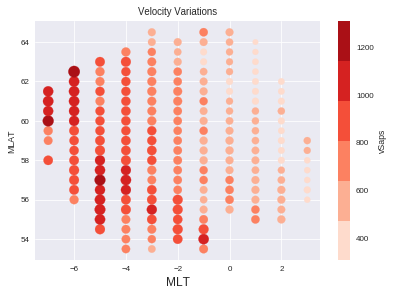

In [3]:
# We'll now divide data into MLT/MLAT bins and get some stats
mltMlatMeanDF = velsDataDF.groupby( [ "normMLT", "MLAT" ] ).mean().reset_index()
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
mltMlatMeanDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=mltMlatMeanDF["vSaps"]/10, cmap=seaMap, ax=ax)
ax.set_ylabel("MLAT")
ax.set_xlabel("MLT", fontsize=12)
ax.set_title( "Velocity Variations" )
plt.savefig("../figs/meanVelMLATMLT.pdf",bbox_inches='tight')

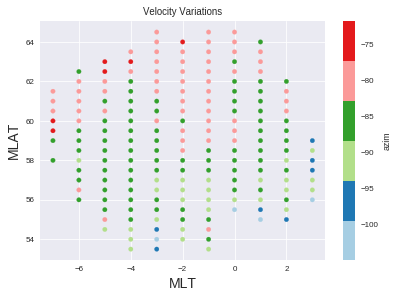

In [4]:
mltMlatMeanDF = velsDataDF[ velsDataDF["goodFit"] ].groupby( [ "normMLT", "MLAT" ] ).mean().reset_index()
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Paired"))

# Plot using matplotlib
fig1 = plt.figure()
ax = fig1.add_subplot(111)
mltMlatMeanDF.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='azim',
              s=20, cmap=seaMap, ax=ax)
ax.set_ylabel("MLAT", fontsize=14)
ax.set_xlabel("MLT", fontsize=14)
ax.set_title( "Velocity Variations" )
plt.savefig("../figs/meanAzimMLATMLT.pdf",bbox_inches='tight')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:21: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


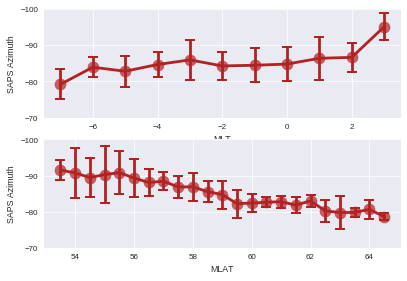

In [5]:
# Plot Mean and Std of Azims vs MLT and MLAT!
azimMLTMeanDF = mltMlatMeanDF[[ "normMLT", "azim" ]].groupby( [ "normMLT" ] ).mean().reset_index()
azimMLTMeanDF.columns = [ "normMLT", "azim_est_mlt_mean" ]
azimMLTStdDF = mltMlatMeanDF[[ "normMLT", "azim" ]].groupby( [ "normMLT" ] ).std().reset_index()
azimMLTStdDF.columns = [ "normMLT", "azim_est_mlt_std" ]
azimMLTMeanDF = pandas.merge( azimMLTMeanDF, azimMLTStdDF, on=[ "normMLT" ] )
# GET MLAT MEAN/STD
azimMLATMeanDF = mltMlatMeanDF[[ "MLAT", "azim" ]].groupby( [ "MLAT" ] ).mean().reset_index()
azimMLATMeanDF.columns = [ "MLAT", "azim_est_mlat_mean" ]
azimMLATStdDF = mltMlatMeanDF[[ "MLAT", "azim" ]].groupby( [ "MLAT" ] ).std().reset_index()
azimMLATStdDF.columns = [ "MLAT", "azim_est_mlat_std" ]
azimMLATMeanDF = pandas.merge( azimMLATMeanDF, azimMLATStdDF, on=[ "MLAT" ] )
# setup fig
fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
# seaborn styling
sns.set_style("whitegrid")
sns.set_context("poster")

azimMLTMeanDF = azimMLTMeanDF.sort(["normMLT"])
ax1.scatter(azimMLTMeanDF['normMLT'],
            azimMLTMeanDF['azim_est_mlt_mean'],
            marker='o',
            color='firebrick',
            alpha=0.7,
            s = 124)
ax1.errorbar(azimMLTMeanDF['normMLT'],\
             azimMLTMeanDF['azim_est_mlt_mean'],\
             yerr=azimMLTMeanDF['azim_est_mlt_std'], \
             color='firebrick', label='', capthick=2., capsize=5.)

# PLOT MLAT MEAN STDs
ax2.scatter(azimMLATMeanDF['MLAT'],
            azimMLATMeanDF['azim_est_mlat_mean'],
            marker='o',
            color='firebrick',
            alpha=0.7,
            s = 124)
ax2.errorbar(azimMLATMeanDF['MLAT'],\
             azimMLATMeanDF['azim_est_mlat_mean'],\
             yerr=azimMLATMeanDF['azim_est_mlat_std'], \
             color='firebrick', label='', capthick=2., capsize=5.)
# plt.rcParams['axes.labelweight'] = 'bold'
ax1.set_ylim( [-70,-100] )
ax2.set_ylim( [-70,-100] )
ax1.set_xlabel("MLT")
ax2.set_xlabel("MLAT")
ax1.set_ylabel("SAPS Azimuth")
ax2.set_ylabel("SAPS Azimuth")
plt.savefig("../figs/meanStdAzim.pdf",bbox_inches='tight')

In [6]:
# Groupby Dst bin
dstLocDF = velsDataDF.groupby( [ "dst_bin", "normMLT", "MLAT" ] ).mean().reset_index()
dstLocDF.head()

,dst_bin,normMLT,MLAT,azim,azimStd,delMLT,goodFit,vSaps,velSTD,endPtMLAT,endPtNormMLT,dtStr,hour,minute,dst_index,AE,AL,AO,AU,count
0,"(-10, 10]",-6.0,57.0,-78.568748,NaN,NaN,0.0,876.795331,NaN,57.17,-6.86,20131208.0,3.0,41.0,8.5,734.0,-564.0,-197.5,170.0,74.0
1,"(-10, 10]",-6.0,59.0,-80.459435,NaN,NaN,0.0,494.335595,NaN,59.08,-6.49,20131208.0,3.0,28.0,8.5,852.0,-575.0,-149.0,277.0,77.0
2,"(-10, 10]",-6.0,59.5,-82.067443,NaN,NaN,0.0,569.048002,NaN,59.58,-6.56,20140912.0,5.0,2.0,-7.0,501.0,-213.0,38.0,288.0,82.0
3,"(-10, 10]",-5.0,57.5,-78.568748,2.560043,1.0,1.0,613.289632,27.986752,57.62,-5.60,20131208.0,3.0,41.0,8.5,734.0,-564.0,-197.5,170.0,130.0
4,"(-10, 10]",-5.0,58.0,-74.707475,4.986104,1.0,1.0,612.784494,48.591520,58.16,-5.59,20131208.0,3.0,41.0,8.5,734.0,-564.0,-197.5,170.0,122.0


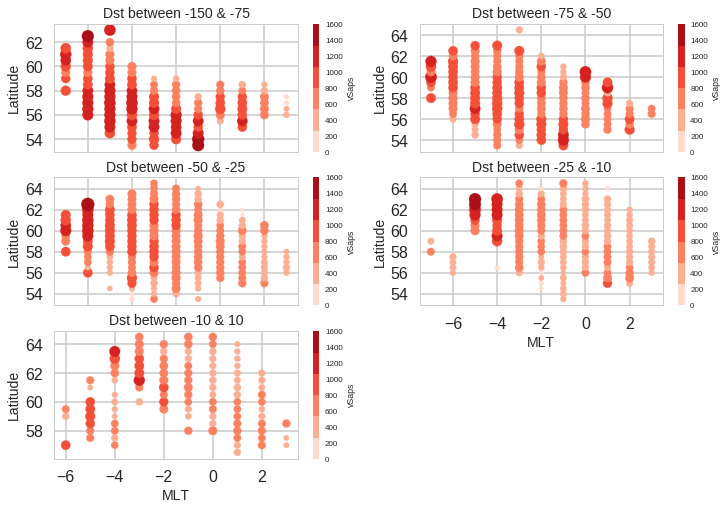

In [7]:
# Make a comparison plot of the data
# for prob of occ at diff locs
# Set up the matplotlib figure
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax5 = f.add_subplot(3,2,5)

velMax = 1600.
velMin = 0.

sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))
# (-150,-75]
dstSapsMLTLat15075 = dstLocDF[ dstLocDF["dst_bin"] == "(-150, -75]" ]
dstSapsMLTLat15075.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=dstSapsMLTLat15075["vSaps"]/10, cmap=seaMap, vmin=velMin, vmax=velMax, ax=ax1, sharex=True)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("Latitude", fontsize=14)
ax1.set_title( "Dst between -150 & -75", fontsize=14 )
# (-75, -50]
dstSapsMLTLat7550 = dstLocDF[ dstLocDF["dst_bin"] == "(-75, -50]" ]
dstSapsMLTLat7550.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=dstSapsMLTLat7550["vSaps"]/10, cmap=seaMap, vmin=velMin, vmax=velMax, ax=ax2)
ax2.set_xlabel("MLT", fontsize=14)
ax2.set_ylabel("Latitude", fontsize=14)
ax2.set_title( "Dst between -75 & -50", fontsize=14 )
# (-50, -25]
dstSapsMLTLat5025 = dstLocDF[ dstLocDF["dst_bin"] == "(-50, -25]" ]
dstSapsMLTLat5025.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=dstSapsMLTLat5025["vSaps"]/10, cmap=seaMap, vmin=velMin, vmax=velMax, ax=ax3)
ax3.set_xlabel("MLT", fontsize=14)
ax3.set_ylabel("Latitude", fontsize=14)
ax3.set_title( "Dst between -50 & -25", fontsize=14 )
# (-25, -10]
dstSapsMLTLat2510 = dstLocDF[ dstLocDF["dst_bin"] == "(-25, -10]" ]
dstSapsMLTLat2510.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=dstSapsMLTLat2510["vSaps"]/10, cmap=seaMap, vmin=velMin, vmax=velMax, ax=ax4)
ax4.set_xlabel("MLT", fontsize=14)
ax4.set_ylabel("Latitude", fontsize=14)
ax4.set_title( "Dst between -25 & -10", fontsize=14 )
# (-10, 10]
dstSapsMLTLat1010 = dstLocDF[ dstLocDF["dst_bin"] == "(-10, 10]" ]
dstSapsMLTLat1010.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=dstSapsMLTLat1010["vSaps"]/10, cmap=seaMap, vmin=velMin, vmax=velMax, ax=ax5)
ax5.set_xlabel("MLT", fontsize=14)
ax5.set_ylabel("Latitude", fontsize=14)
ax5.set_title( "Dst between -10 & 10", fontsize=14 )
plt.savefig("../figs/allDstBinsVels.pdf",bbox_inches='tight')

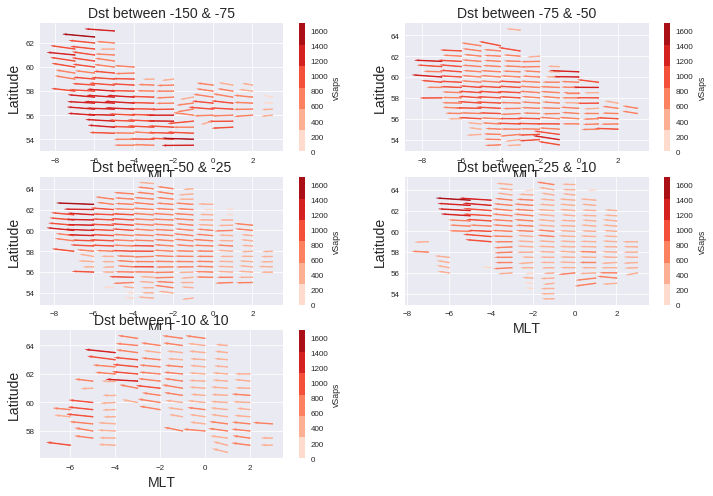

In [8]:
f = plt.figure(figsize=(12, 8))
ax1 = f.add_subplot(3,2,1)
ax2 = f.add_subplot(3,2,2)
ax3 = f.add_subplot(3,2,3)
ax4 = f.add_subplot(3,2,4)
ax5 = f.add_subplot(3,2,5)

# Now setup a velocity scale
velScaleMin = 0.
# round off max velocity to the next hundred
velScaleMax = (dstLocDF["vSaps"].max() + 100.)*100/100\
    - (dstLocDF["vSaps"].max() + 100.)%100

# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
seaMap = ListedColormap(sns.color_palette("Reds"))

fitResultsDF15075 = dstLocDF[ dstLocDF["dst_bin"] == "(-150, -75]" ]     
fitResultsDF15075.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax1)
ax1.set_xlabel("MLT", fontsize=14)
ax1.set_ylabel("Latitude", fontsize=14)
ax1.set_title( "Dst between -150 & -75", fontsize=14 )

plotMLTends = fitResultsDF15075['endPtNormMLT'].tolist()
plotMLATends = fitResultsDF15075['endPtMLAT'].tolist()
plotMLTbegins = fitResultsDF15075['normMLT'].tolist()
plotMLATbegins = fitResultsDF15075['MLAT'].tolist()
plotVelMagns = fitResultsDF15075['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax1.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax1.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
        

fitResultsDF7550 = dstLocDF[ dstLocDF["dst_bin"] == "(-75, -50]" ]     
fitResultsDF7550.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax2)

plotMLTends = fitResultsDF7550['endPtNormMLT'].tolist()
plotMLATends = fitResultsDF7550['endPtMLAT'].tolist()
plotMLTbegins = fitResultsDF7550['normMLT'].tolist()
plotMLATbegins = fitResultsDF7550['MLAT'].tolist()
plotVelMagns = fitResultsDF7550['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax2.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax2.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
ax2.set_xlabel("MLT", fontsize=14)
ax2.set_ylabel("Latitude", fontsize=14)
ax2.set_title( "Dst between -75 & -50", fontsize=14 )


fitResultsDF5025 = dstLocDF[ dstLocDF["dst_bin"] == "(-50, -25]" ]     
fitResultsDF5025.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax3)

plotMLTends = fitResultsDF5025['endPtNormMLT'].tolist()
plotMLATends = fitResultsDF5025['endPtMLAT'].tolist()
plotMLTbegins = fitResultsDF5025['normMLT'].tolist()
plotMLATbegins = fitResultsDF5025['MLAT'].tolist()
plotVelMagns = fitResultsDF5025['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax3.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax3.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        
ax3.set_xlabel("MLT", fontsize=14)
ax3.set_ylabel("Latitude", fontsize=14)
ax3.set_title( "Dst between -50 & -25", fontsize=14 )


        
        
fitResultsDF2510 = dstLocDF[ dstLocDF["dst_bin"] == "(-25, -10]" ]     
fitResultsDF2510.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax4)

plotMLTends = fitResultsDF2510['endPtNormMLT'].tolist()
plotMLATends = fitResultsDF2510['endPtMLAT'].tolist()
plotMLTbegins = fitResultsDF2510['normMLT'].tolist()
plotMLATbegins = fitResultsDF2510['MLAT'].tolist()
plotVelMagns = fitResultsDF2510['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax4.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax4.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
        

ax4.set_xlabel("MLT", fontsize=14)
ax4.set_ylabel("Latitude", fontsize=14)
ax4.set_title( "Dst between -25 & -10", fontsize=14 )        
        
        
fitResultsDF1010 = dstLocDF[ dstLocDF["dst_bin"] == "(-10, 10]" ]     
fitResultsDF1010.plot( kind='scatter',
              x='normMLT',
              y='MLAT',
              c='vSaps',
              s=1., cmap=seaMap, vmin=velScaleMin, vmax=velScaleMax, ax=ax5)

plotMLTends = fitResultsDF1010['endPtNormMLT'].tolist()
plotMLATends = fitResultsDF1010['endPtMLAT'].tolist()
plotMLTbegins = fitResultsDF1010['normMLT'].tolist()
plotMLATbegins = fitResultsDF1010['MLAT'].tolist()
plotVelMagns = fitResultsDF1010['vSaps'].tolist()
# Normalize velocities according to colorbar
colNorm = Normalize( vmin=velScaleMin, vmax=velScaleMax )
for currMLTend, currMLATend, currMLTbgn, currMLATbgn, currVel in\
        zip( plotMLTends, plotMLATends, plotMLTbegins, plotMLATbegins, plotVelMagns ) :
        # get a appropriate color for each bar
        currCol = seaMap( colNorm(currVel) )
        ax5.plot( [currMLTbgn, currMLTend], [ currMLATbgn, currMLATend ], color=currCol )        
        ax5.arrow( currMLTbgn, currMLATbgn, currMLTend-currMLTbgn, currMLATend-currMLATbgn,\
                 head_width=0.15, head_length=0.2, fc=currCol, ec=currCol)
ax5.set_xlabel("MLT", fontsize=14)
ax5.set_ylabel("Latitude", fontsize=14)
ax5.set_title( "Dst between -10 & 10", fontsize=14 )
plt.savefig("../figs/allDstBinsVelVecs.pdf",bbox_inches='tight')

In [9]:
# Not only velocity magnitudes we'd also 
# like to plot azimuths!
# get the end points of vectors
dstLocDF["plot_MLATEnd"] = numpy.round( (dstLocDF["vSaps"]/1000.) *\
                                numpy.cos( numpy.deg2rad(-90-1*dstLocDF["azim"]) ) +\
                                dstLocDF["MLAT"], 2)
dstLocDF["plot_normMLTEnd"] = numpy.round( (dstLocDF["vSaps"]/1000.) *\
                                numpy.sin( numpy.deg2rad(-90-1*dstLocDF["azim"]) ) +\
                                dstLocDF["normMLT"], 2)
# Store the data in a file to be used with IDL
# Calculate the median dst in each dst bin
dstBinMedians = velsDataDF.groupby(["dst_bin"]).median().reset_index()
dstBinMedians = dstBinMedians[ [ "dst_bin", "dst_index" ] ]
dstBinMedians.columns = [ "dst_bin", "dst_median" ]
dstBinMedians.head()
sapsVelstoCsv = dstLocDF[ [ "dst_bin", "normMLT", "MLAT",\
                            "vSaps", "azim", "plot_MLATEnd", "plot_normMLTEnd" ] ]
sapsVelstoCsv = pandas.merge( sapsVelstoCsv, dstBinMedians, on=["dst_bin"] )
sapsVelstoCsv["vSaps"] = sapsVelstoCsv["vSaps"].map( lambda x: round(x,2) )
sapsVelstoCsv["azim"] = sapsVelstoCsv["azim"].map( lambda x: round(x,2) )
sapsVelstoCsv = sapsVelstoCsv[ [ "normMLT", "MLAT",\
                            "vSaps", "azim", "plot_MLATEnd", "plot_normMLTEnd", "dst_median" ] ]
sapsVelstoCsv.to_csv("../data/sapsVelsMagnAzimDst.txt", sep=' ', index=False, header=False)

In [12]:
test = velsDataDF[ (velsDataDF["dst_bin"] == "(-25, -10]") & ( velsDataDF["normMLT"] == -5 ) ]
print test.head()

            azim  azimStd  delMLT goodFit  MLAT  normMLT        vSaps  velSTD  \
10822 -84.728584      NaN     NaN   False  62.5     -5.0  1465.803573     NaN   
10823 -84.728584      NaN     NaN   False  62.5     -5.0  1465.803573     NaN   
10824 -82.702138      NaN     NaN   False  62.5     -5.0  1355.628920     NaN   
10825 -82.702138      NaN     NaN   False  62.5     -5.0  1355.628920     NaN   
10826 -83.450882      NaN     NaN   False  62.5     -5.0  1369.023419     NaN   

       endPtMLAT  endPtNormMLT  ...   minute             dst_date  dst_index  \
10822      62.63         -6.46  ...        0  2013-03-16 05:00:00      -19.0   
10823      62.63         -6.46  ...        0  2013-03-16 05:00:00      -19.0   
10824      62.67         -6.34  ...        2  2013-03-16 05:00:00      -19.0   
10825      62.67         -6.34  ...        2  2013-03-16 05:00:00      -19.0   
10826      62.66         -6.36  ...        4  2013-03-16 05:00:00      -19.0   

          dst_bin     datetimeSt